# Problem Statement

$$\Delta{u} = 4$$

$$u\bigg|_{x = 0} = y^2,\;u\bigg|_{x = 1} = 1 + y^2,\;u\bigg|_{y = 0} = x^2,\;u\bigg|_{y = 1} = 1 + x^2$$

# Precise Solution

$$u(x, y) = x^2 + y^2$$

In [1]:
import numpy as np, scipy as sp
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from scipy import linalg

In [2]:
u = lambda x, y: x ** 2 + y ** 2

# Numerical Solution

* Finite difference sheme

$$\frac{y_{k + 1, l} - 2y_{k, l} + y_{k - 1, l}}{h^2} + \frac{y_{k, l + 1} - 2y_{k, l} + y_{k, l - 1}}{h^2} = 
f_{k, l}$$

$$y_{0, l} = y_l^2,\;y_{1, l} = 1 + y_l^2,\;y_{k, 0} = x_k^2,\;y_{k, 1} = 1 + x_k^2$$

* Using support indices

$$(k, l) \longrightarrow k(N + 1) + l = j,\;(k, l \pm 1) \longrightarrow k(N + 1) + l \pm 1 = j \pm 1$$

$$(k \pm 1, l) \longrightarrow (k \pm 1)(N + 1) + l = k(N + 1) \pm (N + 1) + l = j \pm (N + 1)$$

* Rewriting inital scheme

$$\frac{y_{j + (L + 1)} - 2y_j + y_{j - (L + 1)}}{h^2} + \frac{y_{j + 1} - 2y_j + y_{j - 1}}{h^2} = 
f_j \Longrightarrow y_{j + (L + 1)} + y_{j - (L + 1)} - 4y_j + y_{j + 1} + y_{j - 1} = f_j h^2$$

* Note that $4N$ elements of grid are known from boundary condition.
The number of residual elements is definded as:

$$m = (N + 1) \times (N + 1) - 4N = N^2 + 2N + 1 - 4N = N^2 - 2N + 1 = (N - 1) \times (N - 1)$$

* Using matrix notation

$$\mathbf{A} \in \mathbf{M}^{m\,\times\,m},\;\mathbf{y} \in \mathbf{M}^{m\,\times\,1},\;
\mathbf{f} \in \mathbf{M}^{m\,\times\,1},\;\mathbf{A}\mathbf{y} = \mathbf{f}$$

In [3]:
def prepare_iteration_scheme(step):
    
    # number of steps
    N = int(1 / step) - 1
    
    # creating solution grid
    us = np.zeros((N + 1, N + 1))
    xs = ys = np.linspace(0, 1, N + 1)
    
    # pushing boudary conditions along x
    us[0, :] = np.power(ys, 2)
    us[N, :] = 1 + np.power(ys, 2)
    
    # pushing boudary conditions along y
    us[:, 0] = np.power(xs, 2)
    us[:, N] = 1 + np.power(xs, 2)
    
    # reduction of size due to boundary conditions
    size = N - 1
    
    # preparing left part matrix with actual size after straightening grid to vector
    A = np.zeros((size ** 2, size ** 2))
    
    # creating sqaure with super and sub diagonal
    square = np.diag(-4 * np.ones(size)) + np.diag(np.ones(size - 1), 1) + np.diag(np.ones(size - 1), -1)
    
    # pushing squares along diagonal
    for index in range(size):
        A[index * size: (index + 1) * size, index * (size): (index + 1) * size] += square
    
    # appending wings under and above diagonal
    A += np.diag(np.ones(size ** 2 - size), size) + np.diag(np.ones(size ** 2 - size), -size)
    
    # preparing the right part vector
    f = 4 * step ** 2 * np.ones((size, size))
    
    # subtracting boundary conditions along x
    f[0, :] -= us[0, 1: -1]
    f[size - 1, :] -= us[N, 1: -1]
    
    # subtracting boundary conditions along y
    f[:, 0] -= us[1: -1, 0]
    f[:, size - 1] -= us[1: -1, N]
    
    # straightening right part vector and returning
    return xs, ys, us, A, f.flatten('F')

### Seidel's Method

* Decomposition of initial system $\mathbf{A}\mathbf{x} = \mathbf{f}$

$$\mathbf{A} = \mathbf{L} + \mathbf{D} + \mathbf{U} \Longrightarrow 
(\mathbf{L} + \mathbf{D})\mathbf{y} = -\mathbf{U}\mathbf{y} + \mathbf{f}$$

* Iteration scheme

$$\mathbf{y}_{n + 1} = -(\mathbf{L} + \mathbf{D})^{-1}\mathbf{U}\mathbf{y}_n + 
(\mathbf{L} + \mathbf{D})^{-1}\mathbf{f}$$

In [4]:
def integrate_poisson_equation(step, eps=1e-4, verbose=False):
    
    # preparing solution grid, left part matrix and right part vector
    xs, ys, us, A, f = prepare_iteration_scheme(step)
    size = A.shape[-1]
    
    if verbose:
        print('Grid and linear system prepared!')
    
    # extracting triangular part of matrix
    LD = np.tril(A)
    U = A - LD
                
    # inverting sub diagonal matrix
    invLD = linalg.solve_triangular(LD, np.identity(size), lower=True)
    
    if verbose:
        print('Triangular part of matrix inverted!')
    
    # setting initial condition
    last = np.zeros_like(f)
    y = -invLD @ (U @ last) + invLD @ f
    
    # fixed point iterating with help of Seidel
    count = 0
    while np.linalg.norm(y - last) > eps:
        last = y
        y = -invLD @ (U @ last) + invLD @ f
        
        if verbose and not count % 400:
            print('Norm between sequantial estimation after {}\'th iteration: {:1.2e}'
                  .format(count, np.linalg.norm(y - last)))
        count += 1
        
    if verbose:
        print('Solution found!')
    
    # converting solution vector to square
    square = y.reshape(int(np.sqrt(size)), -1).T
    
    # pushing square to solution grid
    us[1: -1, 1: -1] = square
    
    return xs, ys, us

# Solution Plots

In [5]:
step = 0.02
xs, ys, us = integrate_poisson_equation(step, verbose=True)

Grid and linear system prepared!
Triangular part of matrix inverted!
Norm between sequantial estimation after 0'th iteration: 2.63e+00
Norm between sequantial estimation after 400'th iteration: 1.98e-02
Norm between sequantial estimation after 800'th iteration: 3.82e-03
Norm between sequantial estimation after 1200'th iteration: 7.38e-04
Norm between sequantial estimation after 1600'th iteration: 1.42e-04
Solution found!


### Precise Solution

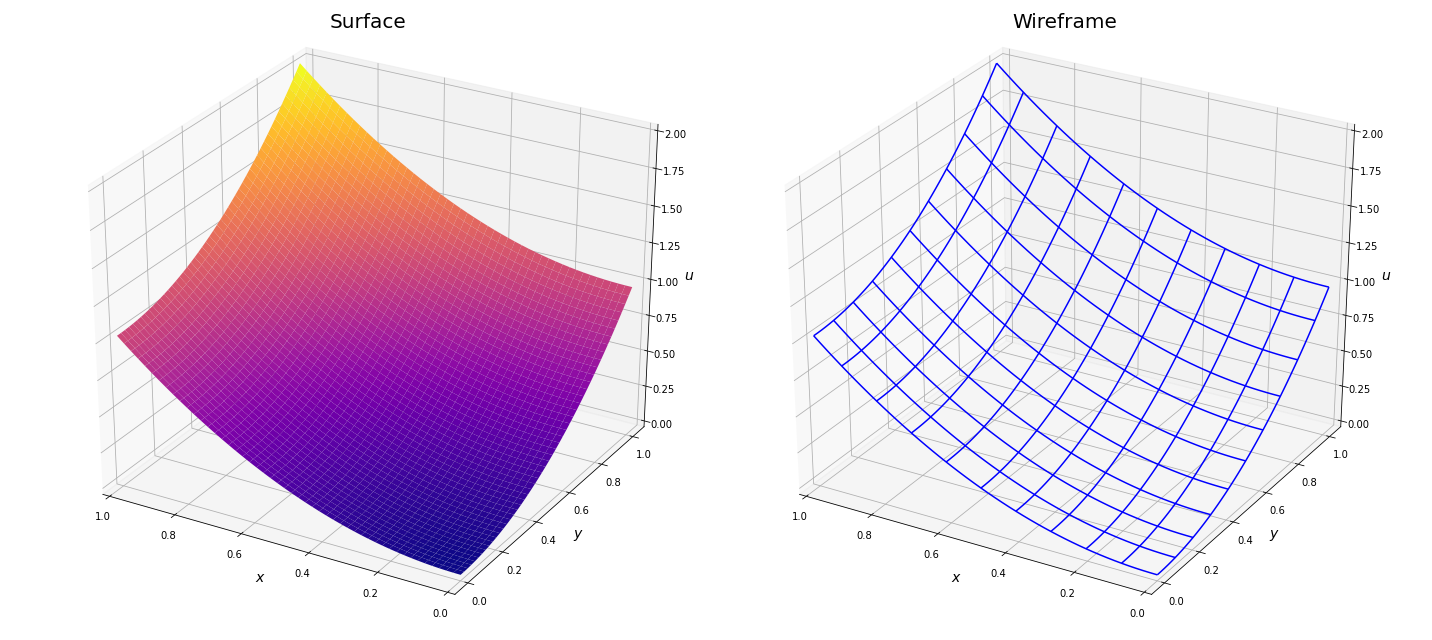

In [6]:
fig = plt.figure(figsize=(20, 9))

# precise surface
Xs, Ys = np.meshgrid(xs, ys)
Us = u(Xs, Ys)

ax = plt.subplot(1, 2, 1, projection='3d')
ax.set_title('Surface', fontsize=20, y=1.04)
ax.zaxis.set_rotate_label(False)

ax.plot_surface(Xs, Ys, Us, rstride=1, cstride=1, cmap='plasma')
ax.set_xlim(1, 0)

ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
ax.set_zlabel('$u$', fontsize=14)

# precise wireframe
ax = plt.subplot(1, 2, 2, projection='3d')
ax.set_title('Wireframe', fontsize=20, y=1.04)
ax.zaxis.set_rotate_label(False)

ax.plot_wireframe(Xs, Ys, Us, rstride=5, cstride=5, color='blue')
ax.set_xlim(1, 0)

ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
ax.set_zlabel('$u$', fontsize=14)

plt.tight_layout(w_pad=-2.5)
# plt.show()
plt.savefig('poisson_equation.png')

### Numerical Solution

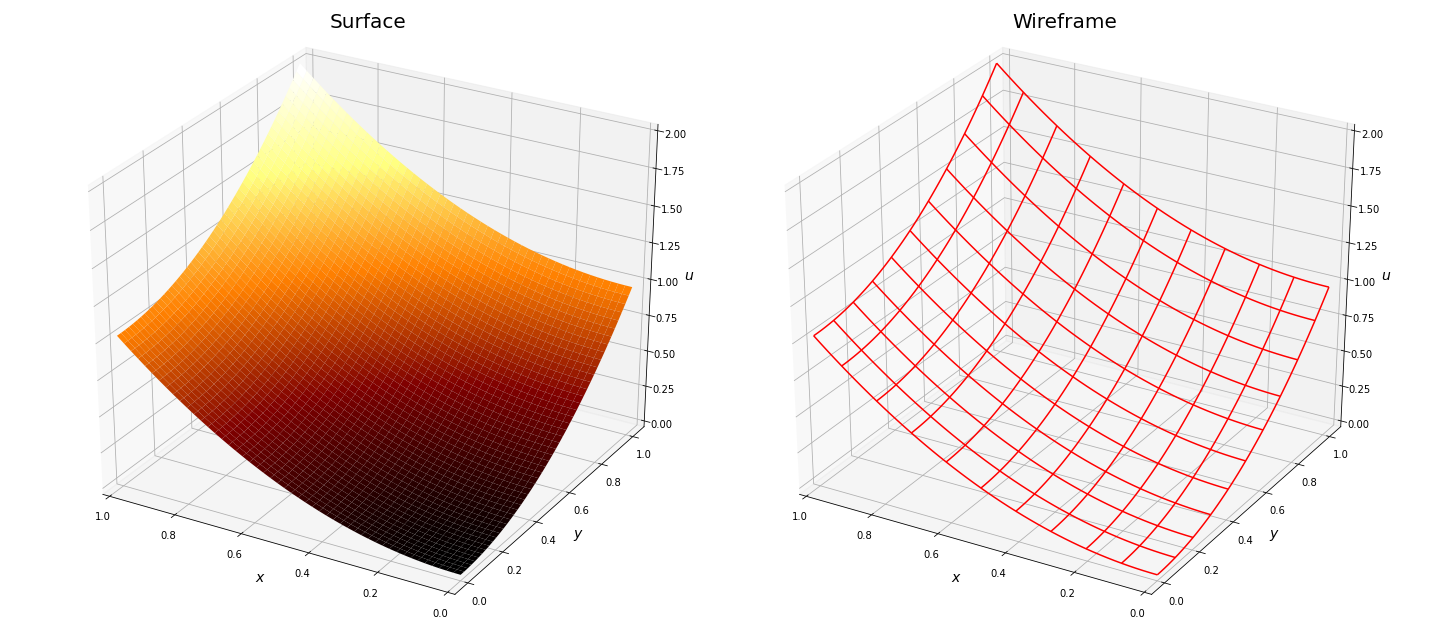

In [7]:
fig = plt.figure(figsize=(20, 9))

# numerical surface
Xs, Ys = np.meshgrid(xs, ys)
Us = us

ax = plt.subplot(1, 2, 1, projection='3d')
ax.set_title('Surface', fontsize=20, y=1.04)
ax.zaxis.set_rotate_label(False)

ax.plot_surface(Xs, Ys, Us, rstride=1, cstride=1, cmap='afmhot')
ax.set_xlim(1, 0)

ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
ax.set_zlabel('$u$', fontsize=14)

# numerical wireframe
ax = plt.subplot(1, 2, 2, projection='3d')
ax.set_title('Wireframe', fontsize=20, y=1.04)
ax.zaxis.set_rotate_label(False)

ax.plot_wireframe(Xs, Ys, Us, rstride=5, cstride=5, color='red')
ax.set_xlim(1, 0)

ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$y$', fontsize=14)
ax.set_zlabel('$u$', fontsize=14)

plt.tight_layout(w_pad=-2.5)
plt.show()